In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
style.use('bmh')

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

Импортируем обработанный датасет и убираем выбросы

In [2]:
df_raw = pd.read_csv('bank.csv', sep = ';')
df = pd.read_csv('data_scaled.csv')

data_types = df_raw.dtypes
int_cols = [df_raw.columns[i] for i in range(df_raw.shape[1]) if data_types[i] == 'int64']
float_cols = [df_raw.columns[i] for i in range(df_raw.shape[1]) if data_types[i] == 'float64']
cat_cols = [df_raw.columns[i] for i in range(df_raw.shape[1]) if data_types[i] == 'O']
y = cat_cols.pop(-1)

from sklearn.neighbors import LocalOutlierFactor

scaler = StandardScaler()
df_out = scaler.fit_transform(df_raw[[*int_cols, *float_cols]])

lof = LocalOutlierFactor(n_neighbors= 20)
outliers_data = lof.fit_predict(df_out)
mask = outliers_data != -1

df_raw = df_raw[mask]
df = df[mask]

In [3]:
X = df.values
y = df_raw['y'].replace(
                {'yes':1, 'no':0}
)

Просто напомним, что классы несбалансированы. Как минимум не стоит использовать accuracy как метрику, как максимум как-то бороться с несбалансированностью классов.

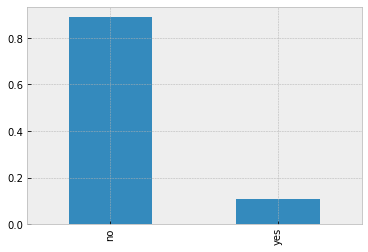

In [4]:
df_raw['y'].value_counts(normalize = True).plot.bar();

Я раньше писал такую штуку для другой работы, просто скопирую сюда и поправлю. Здесь производится поиск по сетке с кросс-валидацией и плоттится значение метрики с ошибками для отбора гиперпараметра по сетке

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [6]:
# тут надо было бы стадартизовать трейн и тест отдельно, но ладно
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    random_state=69)

In [10]:
from matplotlib.pyplot import cm

def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True, multi = False, scoring = 'roc_auc'):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=3, 
                            scoring= scoring,
                            n_jobs=-1, 
                            verbose=1,
                           refit = False)
    CV_model.fit(X, y)
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)
        if (param_scale == 'log'):
            plt.xscale('log')
        if multi:
            color = iter(cm.rainbow(np.linspace(0, 1, len(scoring))))
            
            for score in scoring:
                means = CV_model.cv_results_['mean_test_' + score]
                error = CV_model.cv_results_['std_test_' + score]
                
                plt.plot(grid, means, label='mean values of ' + score, c=next(color), lw=2.5)
                plt.fill_between(grid, means - 2 * error,
                                 means + 2 * error, 
                     color='green', alpha=0.35)
                
            legend_box = plt.legend(framealpha=1).get_frame()
            legend_box.set_facecolor("white")
            legend_box.set_edgecolor("black")
            plt.xlabel('parameter')
            plt.ylabel('score values')
            plt.show()
        else:
            
            means = CV_model.cv_results_['mean_test_score']
            error = CV_model.cv_results_['std_test_score']
            plt.plot(grid, means, label='mean values of score', color='red', lw=3)

            plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                             color='green', label='filled area between errors', alpha=0.5)


    return CV_model

In [8]:
model = KNeighborsClassifier()
param_name = 'n_neighbors'
grid = np.arange(2, 40, 2)
param_scale = 'ordinary'
scoring = ['accuracy','f1', 'average_precision', 'recall', 'roc_auc']

In [ ]:
selection = search_and_draw(X_train, y_train, model, param_name, grid, param_scale, scoring = scoring, multi = True)

Fitting 3 folds for each of 19 candidates, totalling 57 fits


Как и ожидалось, accuracy показывает аномально хорошее качество из-за несбалансированности датасета.  
Recall оказался низким - много наблюдений неверно классифицировалось как False Negative 

Лучше всего отобрать гиперпараметр по f1 метрике - по ней видно переобучение

In [ ]:
max_index = selection.cv_results_['mean_test_f1'].argmax()
max_hyperpar = grid[max_index]

In [ ]:
KNN_best = KNeighborsClassifier(n_neighbors = max_hyperpar)
KNN_best.fit(X_train, y_train)
y_pred = KNN_best.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
best_scores = {
'best_accuracy' :  accuracy_score(y_test, y_pred),
'best_f1' : f1_score(y_test, y_pred),
'best_recall' : recall_score(y_test, y_pred),
'best_roc_auc' : roc_auc_score(y_test, y_pred)
}

In [ ]:
best_scores

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')